In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')


83281/83281 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
195196/195196 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step


In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

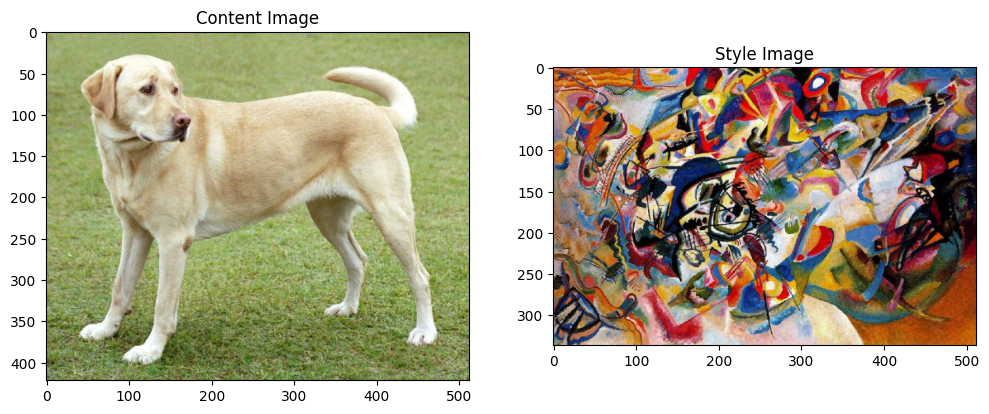

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

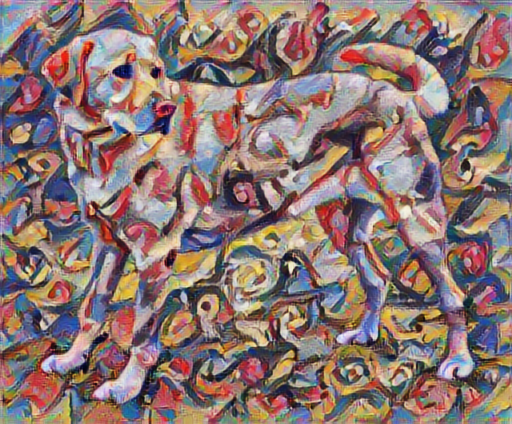

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

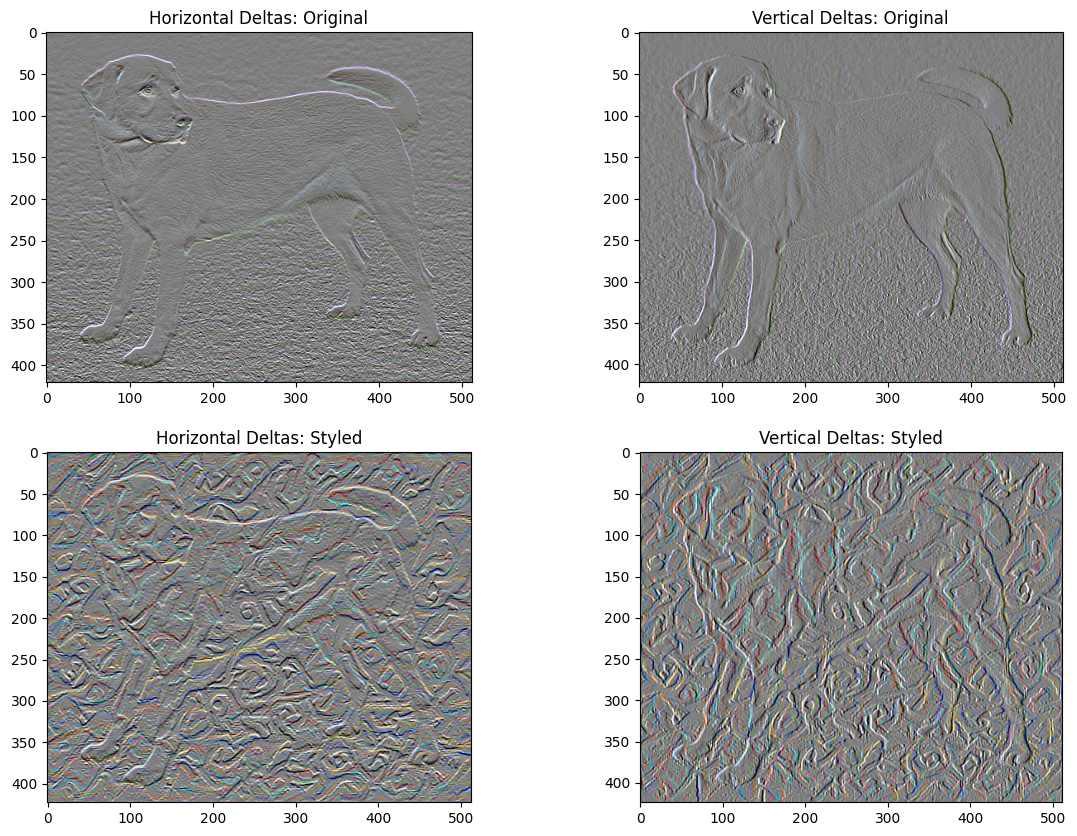

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def clip_0_1(image):
  """
  Clips the values of the image to be between 0 and 1.

  Args:
    image: The image to clip.

  Returns:
    The clipped image.
  """
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(stylized_image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

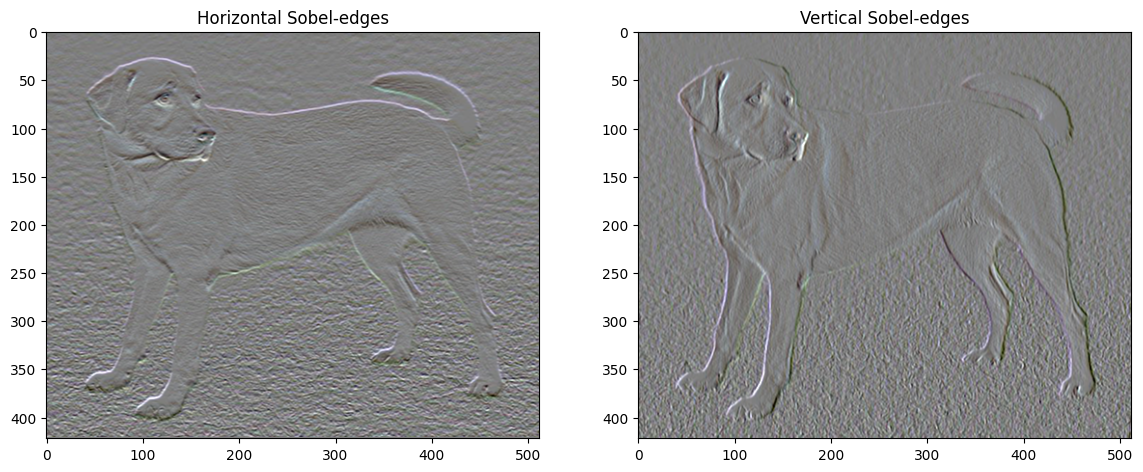

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [ ]:
def total_variation_loss(stylized_image):
  x_deltas, y_deltas = high_pass_x_y(stylized_image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(stylized_image).numpy()

68611.86

In [ ]:
tf.image.total_variation(stylized_image).numpy()

array([68611.86], dtype=float32)

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(stylized_image):
  with tf.GradientTape() as tape:
    outputs = extractor(stylized_image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(stylized_image)

  grad = tape.gradient(loss, stylized_image)
  opt.apply_gradients([(grad, stylized_image)])
  image.assign(clip_0_1(stylized_image))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

In [ ]:
import tensorflow as tf

@tf.function()
def train_step(istylized_image):
  with tf.GradientTape() as tape:
    # Make sure 'image' is used within the style_content_loss calculation
    # For example, if style_content_loss expects the stylized image, you should
    # pass 'image' to it or use it in the calculation of the stylized image.
    outputs = extractor(stylized_image)
    loss = style_content_loss(outputs)

    # The total variation is calculated on the image being optimized (image)
    loss += total_variation_weight * tf.image.total_variation(stylized_image)

  # Calculate gradients with respect to 'image'
  grad = tape.gradient(loss, stylized_image)

  # If grad is None, it means no gradients were calculated.
  # This check helps diagnose the issue.
  if grad is None:
      print("Warning: Gradient is None. Check if 'image' is used in the loss calculation.")
  else:
      opt.apply_gradients([(grad, stylized_image)])

  image.assign(clip_0_1(stylized_image))

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(stylized_image).save(file_name)

try:
  from google.colab import files
  files.download(file_name)
except (ImportError, AttributeError):
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Local paths to your downloaded images
content_path = '/content/gratisography-birthday-dog-sunglasses-1036x780.jpg'  # Update with the actual path
style_path = '/content/gratisography-foliage-face-800x525.jpg'               # Update with the actual path


In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

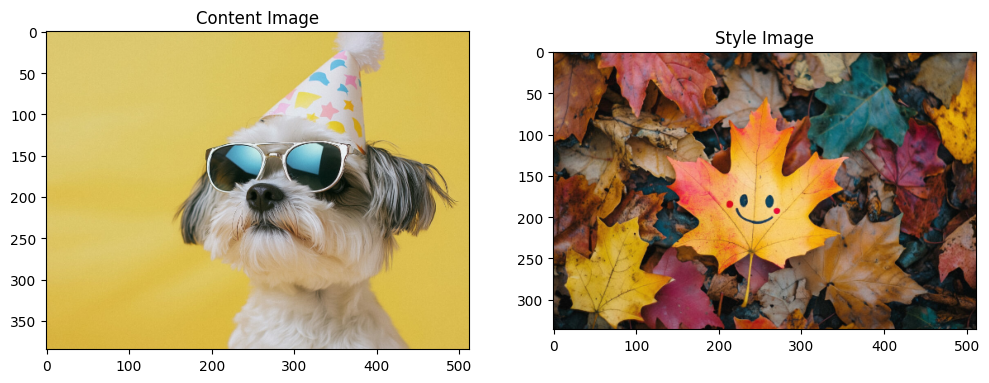

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

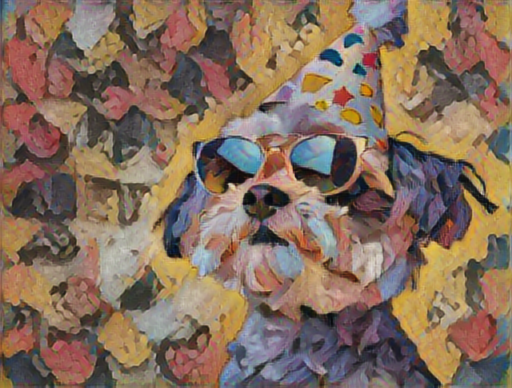

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

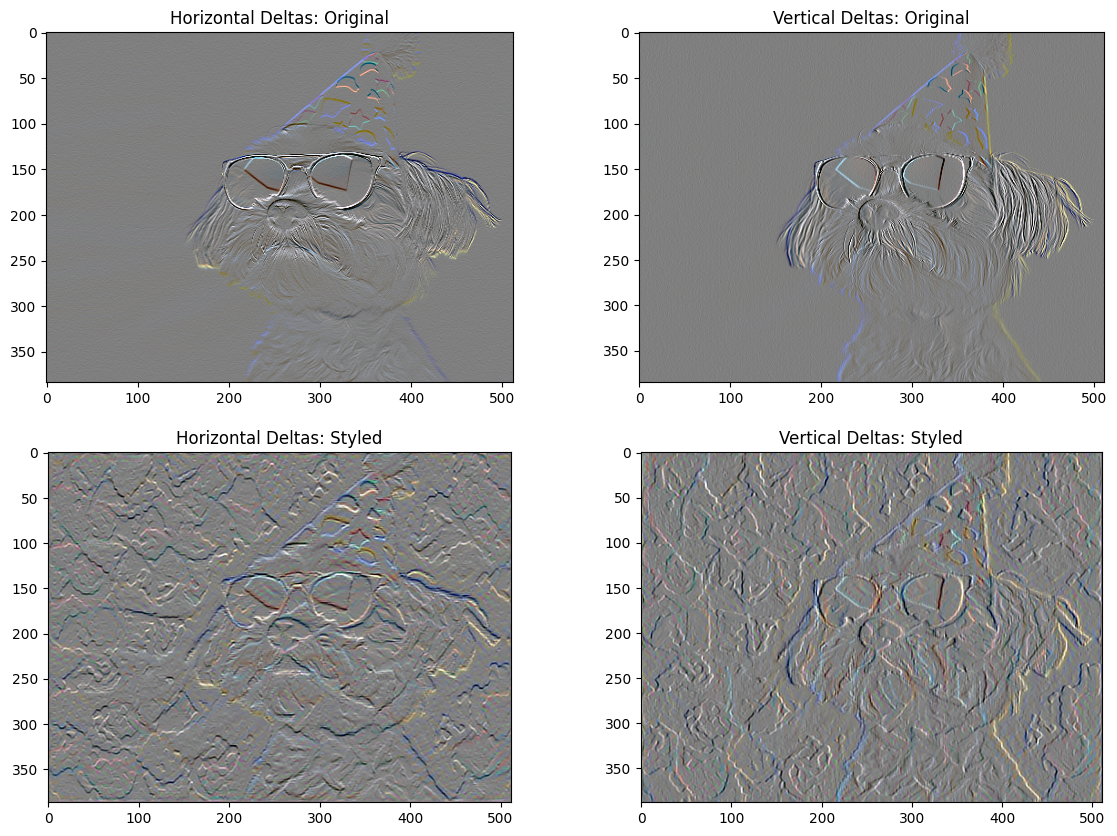

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def clip_0_1(image):
  """
  Clips the values of the image to be between 0 and 1.

  Args:
    image: The image to clip.

  Returns:
    The clipped image.
  """
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(stylized_image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

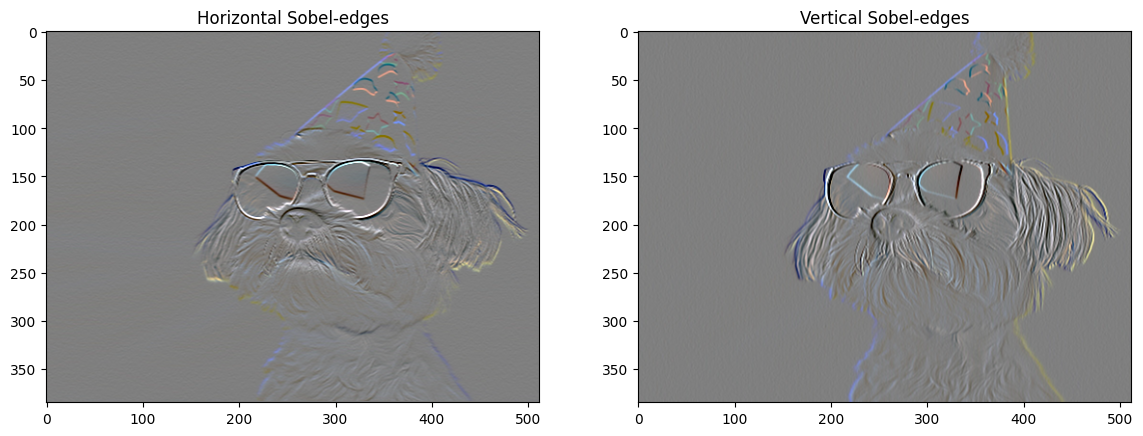

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [ ]:
@tf.function()
def train_step(stylized_image):
  with tf.GradientTape() as tape:
    outputs = extractor(stylized_image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(stylized_image)

  grad = tape.gradient(loss, stylized_image)
  opt.apply_gradients([(grad, stylized_image)])
  image.assign(clip_0_1(stylized_image))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

In [ ]:
import tensorflow as tf

@tf.function()
def train_step(istylized_image):
  with tf.GradientTape() as tape:
    # Make sure 'image' is used within the style_content_loss calculation
    # For example, if style_content_loss expects the stylized image, you should
    # pass 'image' to it or use it in the calculation of the stylized image.
    outputs = extractor(stylized_image)
    loss = style_content_loss(outputs)

    # The total variation is calculated on the image being optimized (image)
    loss += total_variation_weight * tf.image.total_variation(stylized_image)

  # Calculate gradients with respect to 'image'
  grad = tape.gradient(loss, stylized_image)

  # If grad is None, it means no gradients were calculated.
  # This check helps diagnose the issue.
  if grad is None:
      print("Warning: Gradient is None. Check if 'image' is used in the loss calculation.")
  else:
      opt.apply_gradients([(grad, stylized_image)])

  image.assign(clip_0_1(stylized_image))

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(stylized_image).save(file_name)

try:
  from google.colab import files
  files.download(file_name)
except (ImportError, AttributeError):
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>